<a href="https://colab.research.google.com/github/Chun-Ping-Wang/data-course-sample/blob/main/homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*italicized text*# Sample Code

# Exploratory data analysis

## 導入EDA所需的libraries

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
import json, gzip
%matplotlib inline 
sns.set(color_codes=True)

## 載入資料

In [13]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

metadata = getDF('/content/meta_All_Beauty.json.gz')
metadata['price'] = metadata['price'].str.replace(',', '')
metadata['price'] = metadata['price'].str.replace('$', '')
metadata['price'] = pd.to_numeric(metadata['price'], errors='coerce').astype(np.int64,errors='ignore')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

metadata = metadata.replace(np.nan, 0)

metadata.head(5)



--2022-01-02 12:56:34--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.23’

All_Beauty.csv.23   100%[===================>]  14.78M  23.5MB/s    in 0.6s    

2022-01-02 12:56:35 (23.5 MB/s) - ‘All_Beauty.csv.23’ saved [15499476/15499476]

--2022-01-02 12:56:35--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.23’

meta_All_Beauty.jso 100%[===================>]   9.85M  19.2MB/s    in 0.5s

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,0.00,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,0.00,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


## 檢查數據類型

In [14]:
metadata_dtype = metadata.dtypes
print(metadata_dtype)
ratings_dtype = ratings.dtypes
print(ratings_dtype)


category            object
tech1               object
description         object
fit                 object
title               object
also_buy            object
tech2               object
brand               object
feature             object
rank                object
also_view           object
details             object
main_cat            object
similar_item        object
date                object
price              float64
asin                object
imageURL            object
imageURLHighRes     object
dtype: object
asin                      object
reviewerID                object
overall                  float64
unixReviewTime             int64
DATE              datetime64[ns]
dtype: object


## 刪除不相關的列

In [15]:
metadata = metadata.drop(['fit','tech1' ,'tech2', 'date', 'imageURL', 'imageURLHighRes'],axis=1) 
metadata.head (5)

,category,description,title,also_buy,brand,feature,rank,also_view,details,main_cat,similar_item,price,asin
0,[],[Loud 'N Clear Personal Sound Amplifier allows...,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,0.00,6546546450
1,[],[No7 Lift & Luminate Triple Action Serum 50ml ...,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",44.99,7178680776
2,[],[No7 Stay Perfect Foundation now stays perfect...,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,28.76,7250468162
3,[],[],Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,0.00,7367905066
4,[],[Lacto Calamine Skin Balance Daily Nourishing ...,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,12.15,7414204790


## 查看Price分佈

1        44.99
2        28.76
4        12.15
11       24.99
19       21.95
         ...  
32884     5.49
32885    20.74
32887     9.95
32889    55.63
32890    12.99
Name: price, Length: 11270, dtype: float64
8.99 15.99 29.99 55.99 2149.0


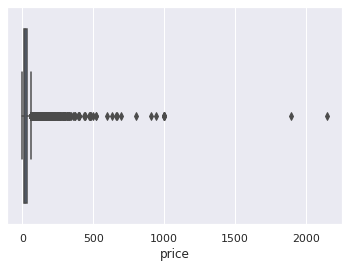

In [16]:
boxspot_price = metadata['price']
boxspot_price = boxspot_price[boxspot_price != 0]
print(boxspot_price)
sns.boxplot(x=boxspot_price)
Q1 = boxspot_price.quantile(0.25)
Q2 = boxspot_price.quantile(0.50)
Q3 = boxspot_price.quantile(0.75)
Q4 = boxspot_price.quantile(1)

Q_09 = boxspot_price.quantile(0.9)
print(Q1,Q2,Q3,Q_09,Q4)



## 查看類別數量

Text(0.5, 0, 'name of brand')

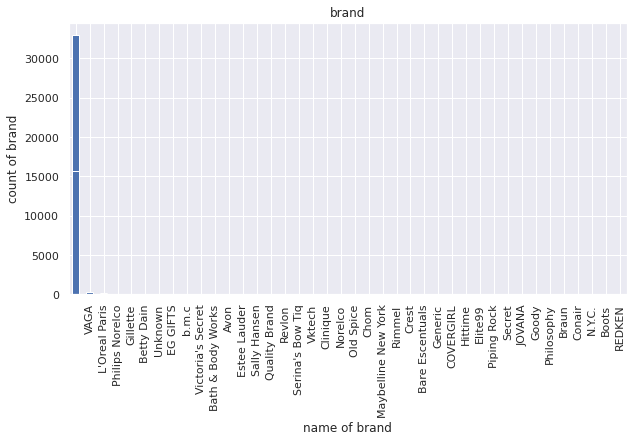

In [18]:
metadata['main_cat'].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title('main_cat')
plt.ylabel('count of cat')
plt.xlabel('name of cat')

metadata['brand'].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title('brand')
plt.ylabel('count of brand')
plt.xlabel('name of brand')

# 推薦代碼

## 基礎建設

In [1]:
import pandas as pd
import gzip, json
import numpy as np
from gensim.parsing.preprocessing import remove_stopwords
import string

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-02 15:01:08--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.35’

All_Beauty.csv.35   100%[===================>]  14.78M  25.0MB/s    in 0.6s    

2022-01-02 15:01:09 (25.0 MB/s) - ‘All_Beauty.csv.35’ saved [15499476/15499476]

--2022-01-02 15:01:09--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.35’

meta_All_Beauty.jso 100%[===================>]   9.85M  18.9MB/s    in 0.5s

In [3]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [4]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [5]:
ratings


,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200
...,...,...,...,...
371340,B01HJEGTYK,A202DCI7TV1022,1.0,1500508800
371341,B01HJEGTYK,A3FSOR5IJOFIBE,5.0,1489622400
371342,B01HJEGTYK,A1B5DK6CTP2P24,5.0,1488326400
371343,B01HJEGTYK,A23OUYS5IRMJS9,2.0,1487635200


## 資料整理

In [6]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')
#metadata['rank'] to int
metadata['rank'] = metadata['rank'].str.split(expand=True)[0]
metadata['rank'] = metadata['rank'].str.replace(',', '')
metadata['rank']  = pd.to_numeric(metadata['rank'], errors='coerce').astype(np.int64,errors='ignore')
#metadata['price'] to int
metadata['price'] = metadata['price'].str.replace(',', '')
metadata['price'] = metadata['price'].str.replace('$', '')
metadata['price'] = pd.to_numeric(metadata['price'], errors='coerce').astype(np.int64,errors='ignore')

metadata = metadata.replace(np.nan, 0)




## 資料切分

In [7]:
#filter1評論時間 1年/6m/3m/2m: 2m表現最好
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01') &
    (ratings['DATE'] >= '2018-07-01')
]
ratings_trainings = ratings_trainings[['asin','reviewerID','overall']]
#ratings_trainings add ['COUNT']
gp_count = ratings_trainings.groupby('asin').count().reset_index()
gp_count['COUNT'] =  gp_count['reviewerID']
gp_count = gp_count[['asin','COUNT']]
ratings_trainings = ratings_trainings.set_index('asin').join(gp_count.set_index('asin'))
ratings_trainings = ratings_trainings.reset_index()
ratings_trainings['COUNT'] = pd.to_numeric(ratings_trainings['COUNT'], errors='coerce').astype(np.int64,errors='ignore')
print(ratings_trainings)

ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

            asin      reviewerID  overall  COUNT
0     B000FOI48G  A2QT2OB69RY8E2      5.0      6
1     B000FOI48G    AS9SS0RS2CHI      5.0      6
2     B000FOI48G  A1DQ9NGS8MQOVC      5.0      6
3     B000FOI48G  A1LXN3903CZLYO      5.0      6
4     B000FOI48G  A22FXBTMFYU6LD      5.0      6
...          ...             ...      ...    ...
4044  B01HGJHL8G   AOXZ0K779O1KK      5.0      4
4045  B01HHWQX8G  A30NK6QIBSY77I      3.0      2
4046  B01HHWQX8G  A3A91XN9GD4NPR      5.0      2
4047  B01HI1YKIG  A2NUTIW490KHMC      4.0      2
4048  B01HI1YKIG  A1NBOIYBASRIO2      5.0      2

[4049 rows x 4 columns]


## 產生推薦(Rule based)

In [8]:
product_df = metadata[['asin','rank','price','also_view']]
mix_df = ratings_trainings.set_index('asin').join(product_df.set_index('asin')) 
mean_df = mix_df.groupby('asin').mean().reset_index() #groupby asin, mean overall and rank
# mean_df = mean_df[mean_df['rank'] < 100000 ] 不採用
# mean_df = mean_df[mean_df['price'] < 30 ] 不採用，嘗試過各種級距的price但無幫助(EDA中)
print(mean_df)

also_v = ratings_trainings[['asin', 'reviewerID']]
also_view = also_v.set_index('asin').join(product_df.set_index('asin')) 
also_view = also_view.reset_index()[['reviewerID','also_view']]
also_view_df = also_view.drop_duplicates(subset='reviewerID', keep=False, ignore_index=True)
print(also_view_df)




#滿意度3/4/4.5/4.8 4表現最好 按評論數降序排列
rb_df = mean_df[mean_df.overall >= 4].sort_values('COUNT', ascending=False).head(10)
rb_list = rb_df['asin'].tolist()
print(rb_df)


            asin  overall  COUNT       rank  price
0     B000FOI48G     5.00      6    19437.0   0.00
1     B000HLCMN0     5.00      1  1438033.0   5.20
2     B000HRRBLC     5.00      1   318902.0  57.59
3     B000MAJD4W     5.00      1   479011.0   0.00
4     B000VH6YM0     5.00      1   314819.0   5.60
...          ...      ...    ...        ...    ...
1654  B01HEYYRIK     3.00      1   271281.0   3.76
1655  B01HFMB6EE     1.00      1   348307.0  11.49
1656  B01HGJHL8G     2.75      4   111113.0   6.19
1657  B01HHWQX8G     4.00      2   254269.0  10.99
1658  B01HI1YKIG     4.50      2    62823.0   8.99

[1659 rows x 5 columns]
          reviewerID                                          also_view
0     A2QT2OB69RY8E2  [B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...
1       AS9SS0RS2CHI  [B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...
2     A1DQ9NGS8MQOVC  [B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...
3     A1LXN3903CZLYO  [B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...
4  

## 產生推薦(Content based)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
# 計算商品用標題所表示的 tfidf 矩陣
input = 'title' #score = 0.005(k=10) 0.001(k=2)
# input = 'mix_data' #score = 0.003(k=10)  0.001(k=2)


# title
df = metadata
# title + description
df['description'] = df['description'].str[0]
df['description'] = df['description'].replace(np.nan, '')
df['mix_data'] = df['title']+df['description']

# 轉換小寫
df[input] = df[input].str.lower()
print(df[input])
# 刪除特殊字元
df[input] = df[input].str.replace('[^a-zA-Z0-9]', ' ')
print(df[input])
# 刪除特殊字元
df[input] = df[input].map(remove_stopwords)
print(df[input])
# 刪除單一a字母
a_z = list(string.ascii_lowercase)
a_z[:] = [" "+word.strip()+" " for word in a_z]
s = pd.Series(a_z)
df[input]= df[input].str.replace('|'.join(s), ' ')

tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(df[input])

# 計算商品間的相似程度
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)
mapping = pd.Series(df.index,index = df[input])

# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k=10):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res


0            loud 'n clear&trade; personal sound amplifier
1        no7 lift &amp; luminate triple action serum 50...
2          no7 stay perfect foundation cool vanilla by no7
3        wella koleston perfect hair colour 44/44 mediu...
4        lacto calamine skin balance oil control 120 ml...
                               ...                        
32887    barielle pro textured grip cuticle nipper, purple
32888    (buy 3 get 1 free) salon perfect eye makeup co...
32889    now d-mannose 500 mg - 120 veg capsules (pack ...
32890    12 white feather shuttlecocks birdies badminto...
32891    feshfen scrunchy scrunchies synthetic hair bun...
Name: title, Length: 32892, dtype: object
0            loud  n clear trade  personal sound amplifier
1        no7 lift  amp  luminate triple action serum 50...
2          no7 stay perfect foundation cool vanilla by no7
3        wella koleston perfect hair colour 44 44 mediu...
4        lacto calamine skin balance oil control 120 ml...
              

In [10]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    content-based
    '''
    ratings_trainings = training_data
    recommendations = {user: recommend_items(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())][input].tolist(), k) for user in users}

    #將content based return為[]的值用rule based填入 
    for key, value in recommendations.items():
          if value == []:
            recommendations[key] = rb_list

    #將also view有資料的viewer推薦此比資料
    # user_also_view_df = pd.DataFrame(users,columns=['reviewerID'])
    # print(user_also_view_df)
    # u_mix_a = also_view_df.set_index('reviewerID').join(user_also_view_df.set_index('reviewerID')).reset_index()

    

    return recommendations

    
    
 


ratings_by_user = recommender(ratings_trainings, users)

## 結果評估

In [11]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    print(score)

evaluate(ratings_testings_by_user, ratings_by_user)

0.05593220338983051
